In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

SEED = 1

In [2]:
%%time

df_train_start = pd.read_csv('train.csv')
df_train = df_train_start

<timed exec>:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 2min 52s
Wall time: 7min 46s


In [3]:
df_test_start = pd.read_csv('test.csv')
df_test = df_test_start.copy()

C:\Users\dmitry\AppData\Local\Temp\ipykernel_13760\3899482319.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test_start = pd.read_csv('test.csv')


In [ ]:
print('Количество строк (семплов) в датасете - {0}, столбцов (признаков) - {1}'.format(*df_train.shape))

Количество строк (семплов) в датасете - 1575021, столбцов (признаков) - 65


# Анализ признаков

In [9]:
df_train_start.city.value_counts()

city
Miami           17961
Columbus        17908
Jacksonville    16580
Tampa           15312
Orlando         14456
                ...  
Boones Mill         1
La Porte            1
Colma               1
Stilwell            1
Ocean City          1
Name: count, Length: 3057, dtype: int64

In [6]:
px.histogram(
    df_train_start.city.value_counts(),  # датасет
    # 'price',  # столбец, для которого требуется построить гистограмму
    title='df_train_start.city.value_counts()',  # название графика
    width=800, height=400
)

In [4]:
sns.set(
    rc = {  # параметры графика
        'figure.figsize': (14, 8),  # (ширина, высота)
    },
    font_scale=0.8,  # размер шрифта
)

<Axes: >

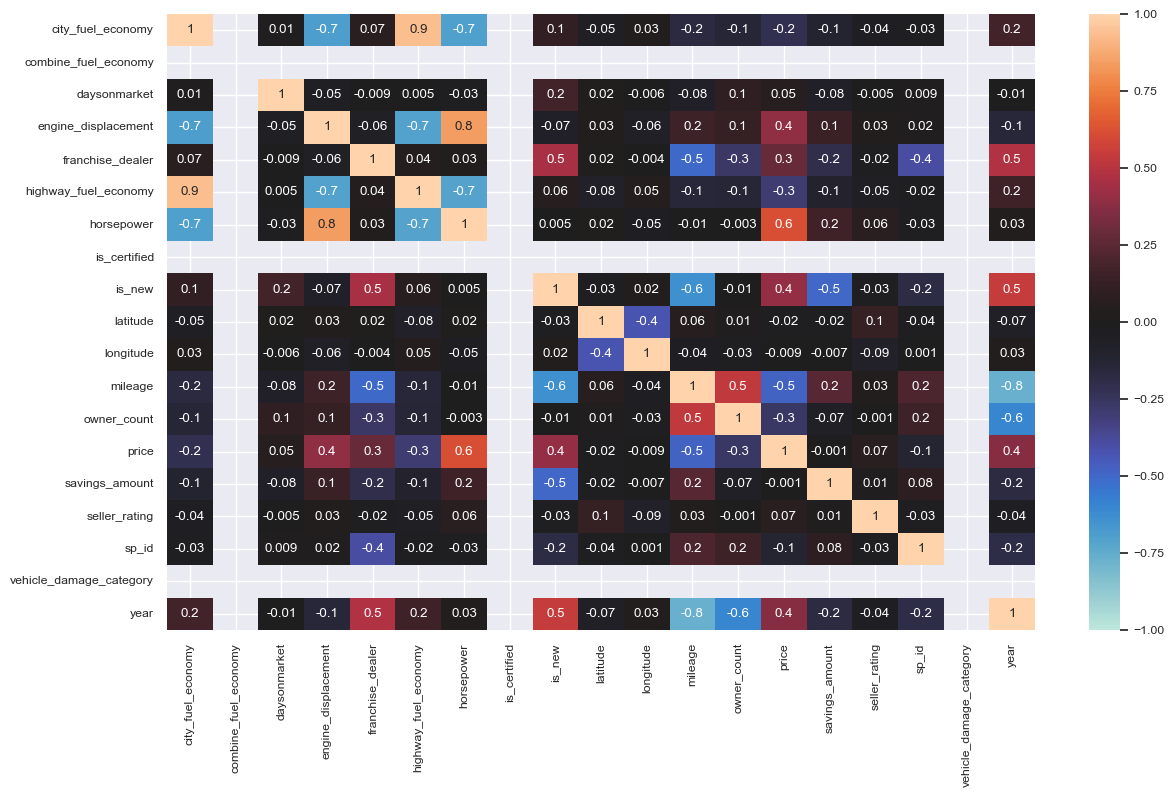

In [5]:
df_num_data = df_train_start._get_numeric_data()  # числовые данные
df_corr = df_num_data.corr()  # коэффициенты корреляции
sns.heatmap(
    df_corr,  # датасет
    annot=True,  # вывод значений в ячейках
    fmt='.1g',  # формат значений
    vmin=-1,  # нижнее значение цветовой гаммы
    vmax=1,  # верхнее значение цветовой гаммы
    center=0,  # среднее значение цветовой гаммы
)

<Axes: >

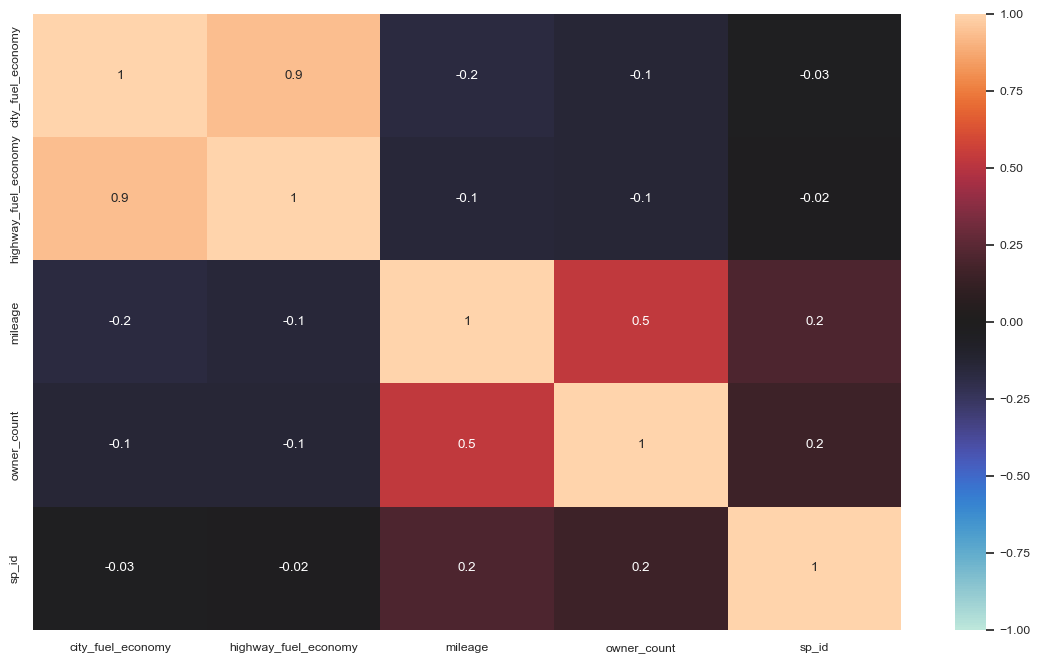

In [6]:
mask = df_corr.price < -0.1
sns.heatmap(
    df_corr.loc[mask, mask],  # датасет
    annot=True,  # вывод значений в ячейках
    fmt='.1g',  # формат значений
    vmin=-1,  # нижнее значение цветовой гаммы
    vmax=1,  # верхнее значение цветовой гаммы
    center=0,  # среднее значение цветовой гаммы
)

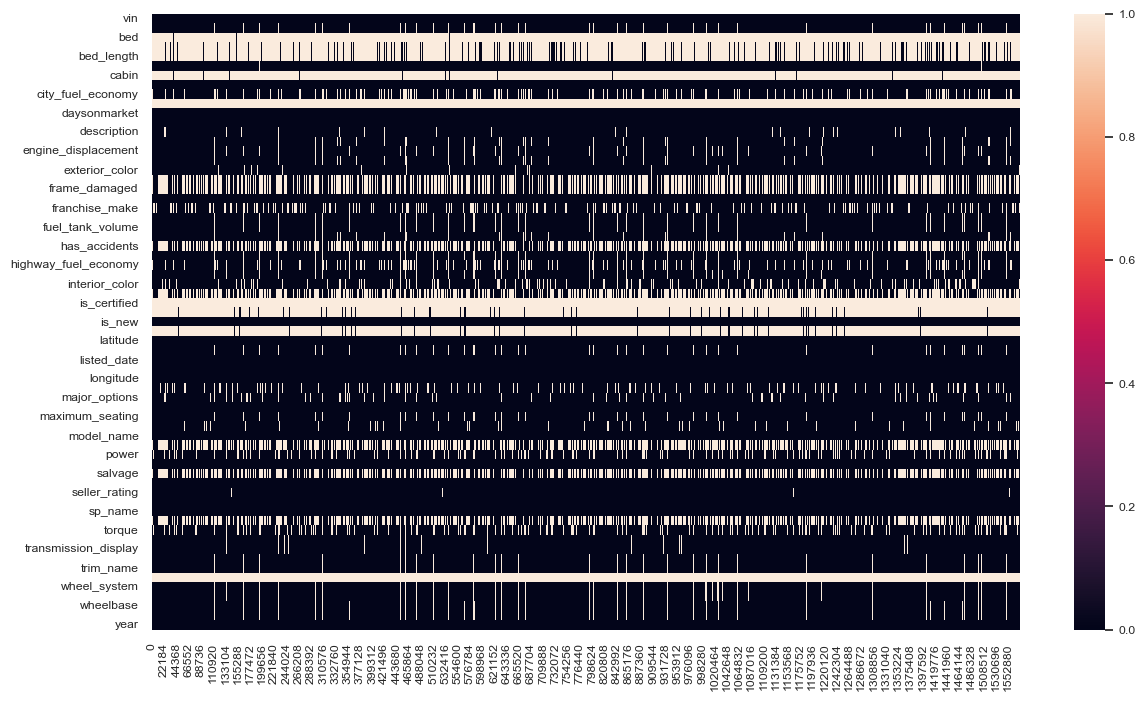

In [7]:
sns.heatmap(df_train.isna().transpose());

# Используемые признаки и заполнение пропусков

In [ ]:
features = [
    'horsepower',
    'year',
    'city_fuel_economy',
    'is_new',
    'highway_fuel_economy',
    'mileage',
    'owner_count',
    'make_name',
    'salvage',
    'model_name'
]

In [ ]:
df_train['horsepower'] = df_train.horsepower.fillna(df_train.horsepower.mean())
df_train['city_fuel_economy'] = df_train.city_fuel_economy.fillna(df_train.city_fuel_economy.mean())
df_train['highway_fuel_economy'] = df_train.highway_fuel_economy.fillna(df_train.highway_fuel_economy.mean())
df_train['mileage'] = df_train.mileage.fillna(df_train.mileage.mean())
df_train['owner_count'] = df_train.owner_count.fillna(df_train.owner_count.mean())

df_train['make_name'] = df_train.make_name.fillna('-1')
df_train['make_name'] = df_train.make_name.fillna('-2')
df_train['salvage'] = df_train.salvage.fillna('False')

In [ ]:
df_test = df_test_start[['vin', *features]].copy()

In [ ]:
df_test['horsepower'] = df_test.horsepower.fillna(df_test.horsepower.mean())
df_test['city_fuel_economy'] = df_test.city_fuel_economy.fillna(df_test.city_fuel_economy.mean())
df_test['highway_fuel_economy'] = df_test.highway_fuel_economy.fillna(df_test.highway_fuel_economy.mean())
df_test['mileage'] = df_test.mileage.fillna(df_test.mileage.mean())
df_test['owner_count'] = df_test.owner_count.fillna(df_test.owner_count.mean())

df_test['make_name'] = df_test.make_name.fillna('-1')
df_test['salvage'] = df_test.salvage.fillna('False')
df_test['make_name'] = df_test.make_name.fillna('-2')

In [ ]:
new_features = dict() # в этом словаре будут хранится названия категорийных признаков, подлежащие замене, и списки названий новых признаков взамен старых

In [ ]:
df_train = df_train[[*features, 'price']].dropna() # выкидывает строки, где что-то пропущенно
df_train.index = range(0, df_train.shape[0]) # чтобы индексы снова были 0, 1, 2, ...

# Обработка категориальных признаков

### model_name

In [ ]:
feature_name = 'model_name'

In [ ]:
if (feature_name in features):
    # группируем пары модель-цена по модели автомобиля, вычисляем среднюю цену для каждой модели, и сортируем получившейся набор данных по цене
    feature_value_distribution = df_train[[feature_name, 'price']].groupby(feature_name).mean().sort_values('price', ascending=False)
    
    # задаем границы и шаг диапазонов для разбиения средней цены модели авто
    if (feature_name in features):
        diap_left_values = list(range(0, int(feature_value_distribution['price'].max()), 1000)) # список левых границ диапазонов

In [ ]:
if (feature_name in features):
    diap_ids = range(0, len(diap_left_values)) # список номеров диапазонов
    diap_names = [] # список имен диапазонов
    diap_right_values = diap_left_values[1:] + [int(feature_value_distribution['price'].max()) + 1] # список правых границ диапазонов
    diap_values_list = [] # списки значений категорийного признака, попадающих в каждый диапазон

In [ ]:
# вычисляем какие модели автомобилей попали в каждый диапазон
if (feature_name in features):
    for i, left, right in zip(diap_ids, diap_left_values, diap_right_values):

        diap_names.append(feature_name + '_' + str(i+1))

        diap_values_list.append(
            # пересечение двух множеств: модели авто, средняя цена которых > левого значения диапазона и средняя цена которых < правого значения
            list(
                set(feature_value_distribution['price'][(feature_value_distribution['price'] > left)].index)
                &
                set(feature_value_distribution['price'][(feature_value_distribution['price'] <= right)].index)
            )
        )

In [ ]:
# заменяем старые значения признака на имя диапазона, в котороый попала средняя цена модели
if (feature_name in features):
    for i in diap_ids:
        df_train.loc[
            df_train[feature_name].isin(diap_values_list[i]), feature_name
        ] = diap_names[i]

In [ ]:
if (feature_name in features):
    # далее onehotencoding получившегося признака
    onehotencoder = OneHotEncoder(handle_unknown = 'ignore')
    # параметр handle_unknown = 'ignore'
    # он означает, что когда onehotencoding будет обучен, и метод transform будет применен на другом датасете (в частности, на df_test),
    # новые значения, которые не встретились при обучении, будут игнорироваться (например, марки машин ['Pagani', 'Spyker'])

    feature_new = onehotencoder.fit_transform(df_train[[feature_name]]) # обучение и применение onehotencoding'а на тренировочной выборке

    df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результата fit_transform()

    # обновляем значения категорийного признака значениями типа feature_name_1, feature_name_2,... для тестовой выборки
    for i in diap_ids:
        df_test.loc[
            df_test[feature_name].isin(diap_values_list[i]), feature_name
        ] = diap_names[i]

    feature_new = onehotencoder.transform(df_test[[feature_name]]) # применение обученного onehotencoding'а на тестовой выборке
    df_test[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результата transform()

    # далее удаляем старые категориные признаки из обоих датасетов
    df_train = df_train.drop([feature_name], axis=1)
    df_test = df_test.drop([feature_name], axis=1)

    # дополняем словарь новыми названиями признаков
    new_features[feature_name] = list(onehotencoder.categories_[0])

C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результата fit_transform()
C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и р

C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результата fit_transform()
C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и р

C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результата fit_transform()
C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и р

C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результата fit_transform()
C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и р

C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результата fit_transform()
C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и р

C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результата fit_transform()
C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и р

C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результата fit_transform()
C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и р

C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результата transform()
C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результ

C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результата transform()
C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результ

C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результата transform()
C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3181465376.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результ

### make_name

In [ ]:
feature_name = 'make_name'
# Преобразование категории make_name производится по аналогии с model_name, за исключением того, что вместо средней цены используется популярность марки автомобиля.
# Под популярностью имеется ввиду число объявлений в датасете, соответствующее марке

if (feature_name in features):
    diap_left_values = list(range(0, df_train.make_name.value_counts().max(), 1000))

In [ ]:
if (feature_name in features):

    feature_value_counts = df_train[feature_name].value_counts()

    diap_ids = range(0, len(diap_left_values)) # список номеров всех диапазонов
    diap_names = [] # список имен новых признаков
    diap_right_values = diap_left_values[1:] + [df_train[feature_name].value_counts().max()]
    diap_values_list = [] # списки значений категорийного признака, попадающих в каждый диапазон

    for i, left, right in zip(diap_ids, diap_left_values, diap_right_values):

        diap_names.append(feature_name + '_' + str(i+1))

        diap_values_list.append(
            # пересечение двух множеств: значений <future_name>, популярность которых > левого значения диапазона и популярность которых < правого значения
            list(
                set(feature_value_counts[(feature_value_counts > left)].index)
                &
                set(feature_value_counts[(feature_value_counts <= right)].index)
            )
        )

    for i in diap_ids:
        df_train.loc[
            df_train[feature_name].isin(diap_values_list[i]), feature_name
        ] = diap_names[i]

    # далее onehotencoding получившегося признака
    onehotencoder = OneHotEncoder(handle_unknown = 'ignore')

    feature_new = onehotencoder.fit_transform(df_train[[feature_name]]) # обучение и применение onehotencoding'а на тренировочной выборке

    df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результата fit_transform()

    for i in diap_ids:
        df_test.loc[
            df_test[feature_name].isin(diap_values_list[i]), feature_name
        ] = diap_names[i]

    feature_new = onehotencoder.transform(df_test[[feature_name]]) # применение обученного onehotencoding'а на тестовой выборке
    df_test[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результата transform()

    # далее удаляем старые категориные признаки из обоих датасетов
    df_train = df_train.drop([feature_name], axis=1)
    df_test = df_test.drop([feature_name], axis=1)

    # дополняем словарь новыми названиями признаков
    new_features[feature_name] = list(onehotencoder.categories_[0])

C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3492283217.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результата fit_transform()
C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3492283217.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и р

C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3492283217.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и результата fit_transform()
C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3492283217.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[list(onehotencoder.categories_[0])] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_) # слияние датасета и р

### salvage ()

In [ ]:
feature_name = 'salvage'

if (feature_name in features):
    # обучение и преобразование признака на тренировочной выборке
    feature_old = pd.DataFrame(df_train[feature_name].replace(True, 'salvage_is_true').replace(False, np.nan))

    onehotencoder = OneHotEncoder()
    feature_new = onehotencoder.fit_transform(feature_old)

    df_train['salvage_is_true'] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_)['salvage_is_true']

    # преобразование на тестовой
    feature_old = pd.DataFrame(df_test[feature_name].replace(True, 'salvage_is_true').replace(False, np.nan))

    feature_new = onehotencoder.transform(feature_old)
    df_test['salvage_is_true'] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_)['salvage_is_true']

    # запоминаем, чтобы затем удалить исходный признак и добавить новый
    new_features[feature_name] = ['salvage_is_true']

C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3270269642.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train['salvage_is_true'] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_)['salvage_is_true']
C:\Users\vk892\AppData\Local\Temp\ipykernel_14420\3270269642.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['salvage_is_true'] = pd.DataFrame(feature_new.toarray(), columns=onehotencoder.categories_)['salvage_is_true']


In [ ]:
# Здесь удаляем из списка признаков старые категорийные признаки и добавляем взамен них новые - численные
for i in new_features:
    if (i in new_features):
        features.remove(i)
        features += new_features[i]


# Обучение модели

In [ ]:
X = df_train[features]
y = df_train.price
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED)

In [ ]:
print('Размер тренировочной выборки:', len(X_train.index))
print('Размер тестовой выборки:', len(X_test))

Размер тренировочной выборки: 1260016
Размер тестовой выборки: 315005


In [ ]:
from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

model = XGBRegressor(max_depth = 7, n_estimators = 1000)

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

RMSE: 5019.001171797435


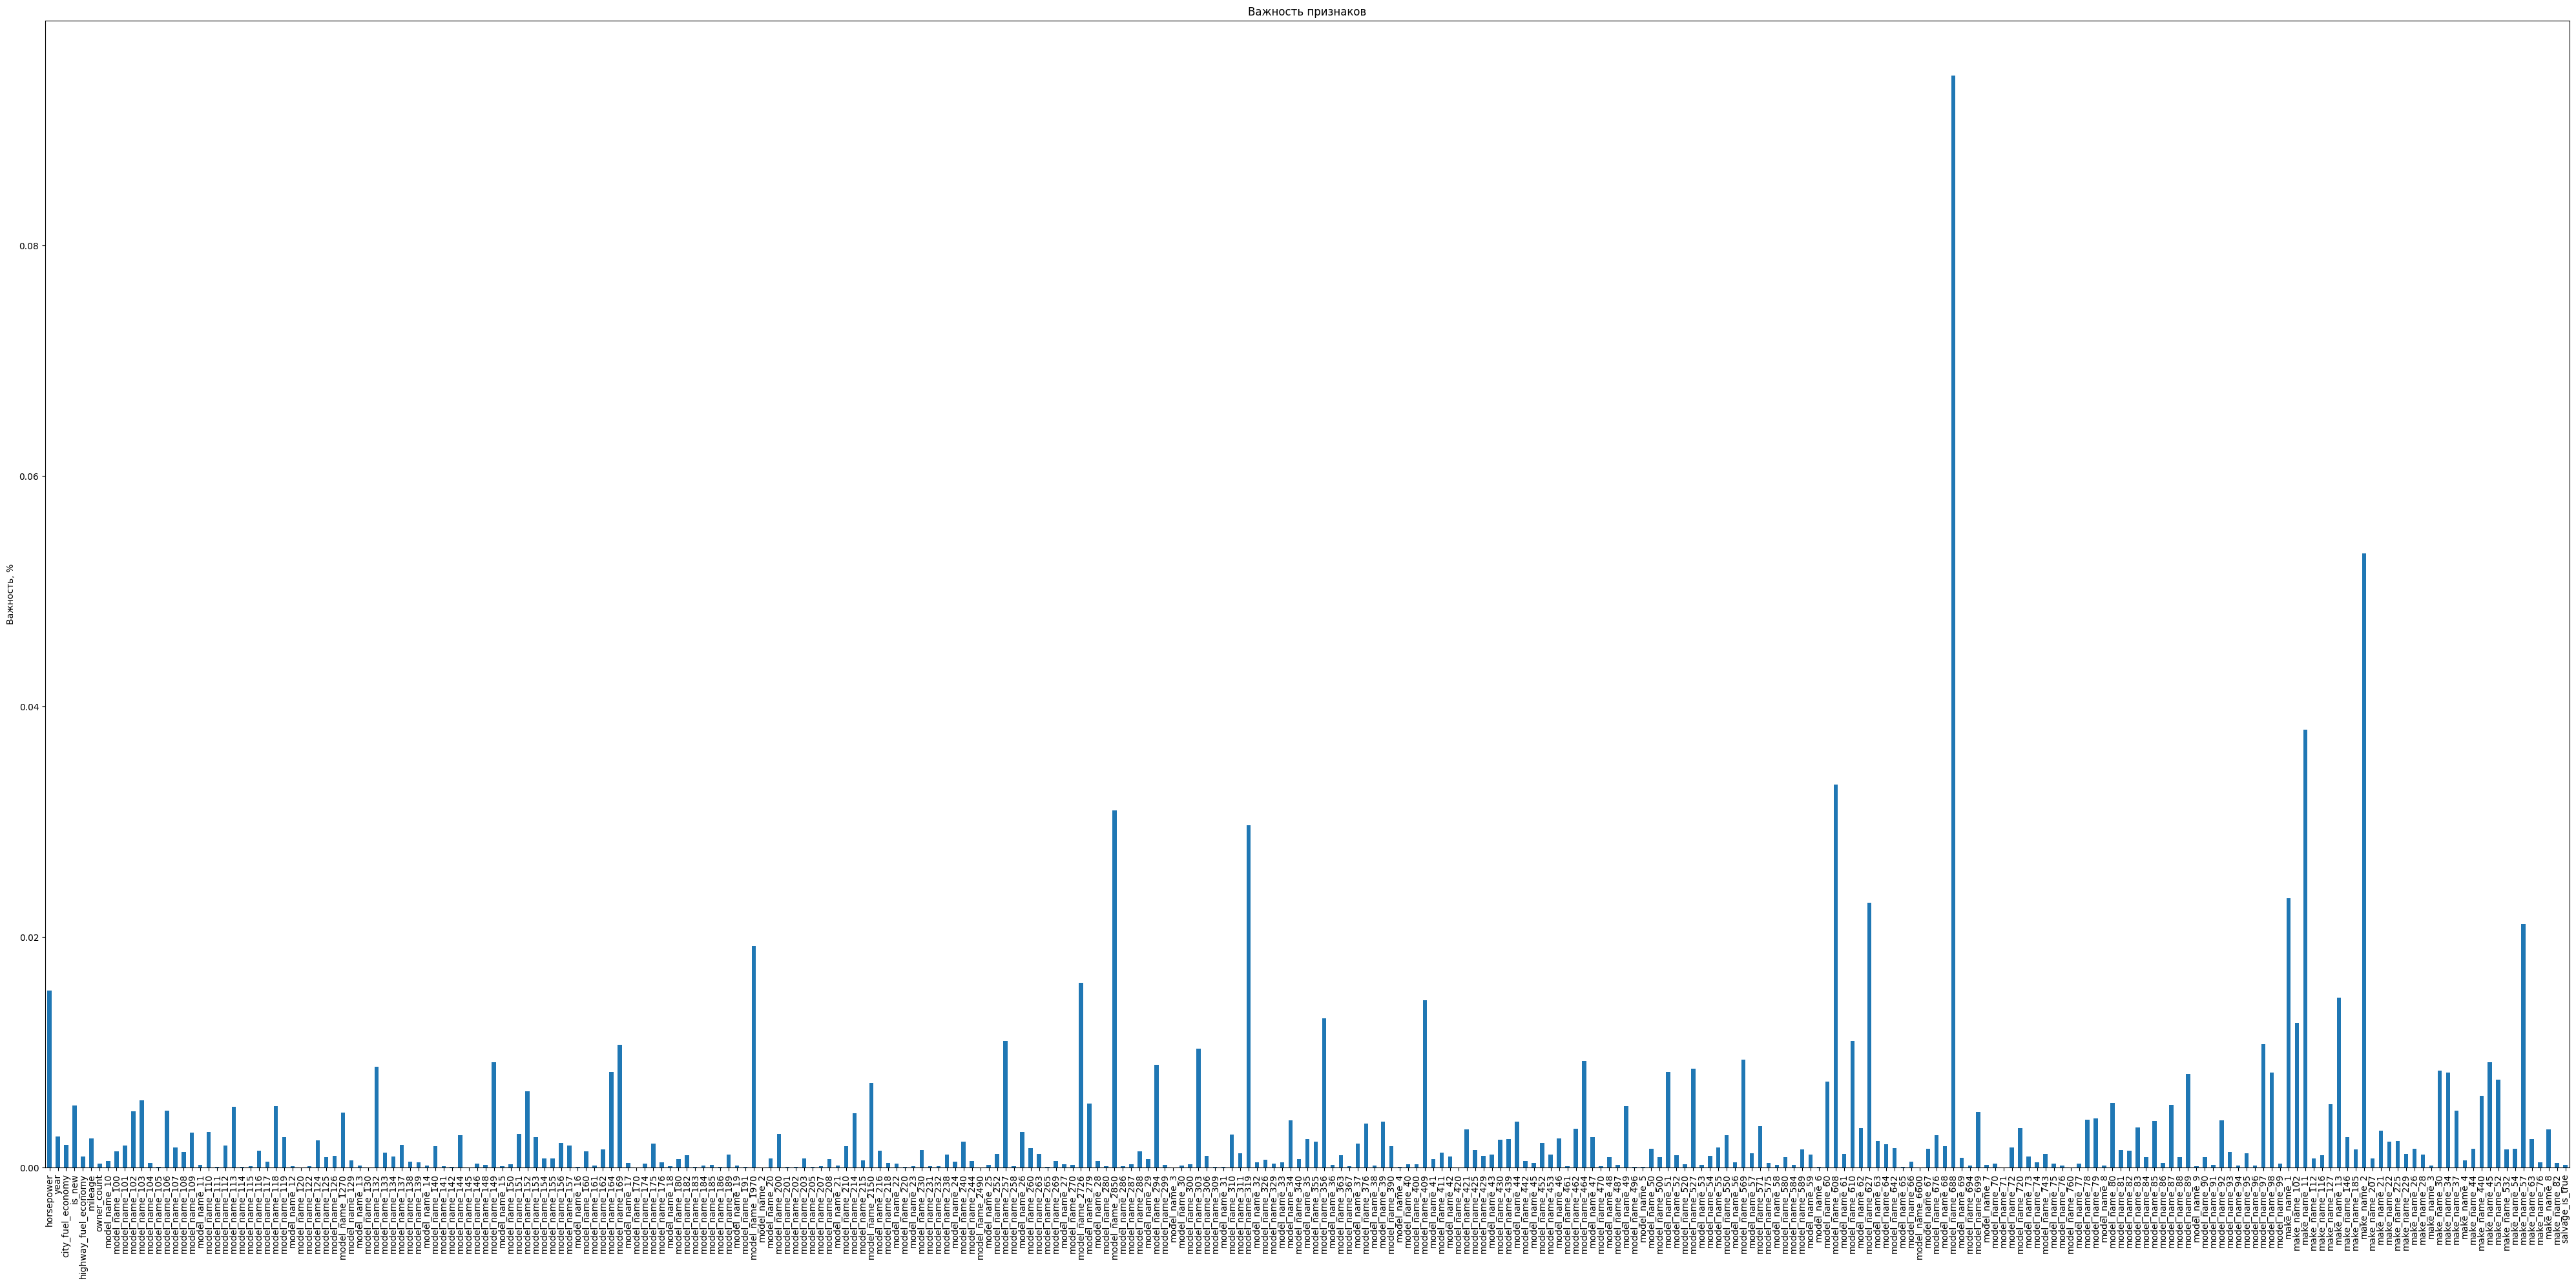

In [ ]:
cat_iris_imp = pd.Series(model.feature_importances_, X_train.columns)
fig, ax = plt.subplots(figsize=(40,20))
cat_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

In [ ]:
model.fit(df_train[features], df_train['price'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Предсказание цены

In [ ]:
df_submission = pd.read_csv('submission.csv')
df_submission.head(2)

,vin,price
0,ZACNJBB5KPJ92081,23555.705
1,SALCJFX1LH858117,46723.703


In [ ]:
df_test['price'] = model.predict(df_test[features])


In [ ]:
df_test[['vin', 'price']].to_csv('submission.csv', index=False)